# Rendering *FEniCS* FEM data with *yt*  

The motivation for this is to render the Finite Element simulation results from *FEniCS* in *yt* where both projects are *NumFocus* projects; thereby removing the need to store and recall the *FEniCS* output in *vtk*

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Rendering-FEniCS-FEM-data-with-yt" data-toc-modified-id="Rendering-FEniCS-FEM-data-with-yt-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Rendering <em>FEniCS</em> FEM data with <em>yt</em></a></span></li><li><span><a href="#Thanks" data-toc-modified-id="Thanks-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Thanks</a></span></li><li><span><a href="#Install-Fenics-and-VirEnv" data-toc-modified-id="Install-Fenics-and-VirEnv-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Install Fenics and VirEnv</a></span></li><li><span><a href="#FEniCS-ex" data-toc-modified-id="FEniCS-ex-4"><span class="toc-item-num">4&nbsp;&nbsp;</span><em>FEniCS</em> ex</a></span></li><li><span><a href="#fenics--&gt;-yt" data-toc-modified-id="fenics-->-yt-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>fenics -&gt; yt</a></span></li><li><span><a href="#Viewing-the-displacement-in-yt" data-toc-modified-id="Viewing-the-displacement-in-yt-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Viewing the displacement in <em>yt</em></a></span></li><li><span><a href="#Loading-and-viewing-the-stress" data-toc-modified-id="Loading-and-viewing-the-stress-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Loading and viewing the stress</a></span></li><li><span><a href="#Viewing-the-displacement-magnitude-in-yt" data-toc-modified-id="Viewing-the-displacement-magnitude-in-yt-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Viewing the displacement magnitude in <em>yt</em></a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Conclusion</a></span></li><li><span><a href="#To-Do" data-toc-modified-id="To-Do-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>To Do</a></span></li></ul></div>

# Thanks
thanks to  Matthew Turk (@powersoffour) in helping to this working via: 
Re: [yt-project/yt] load fenics data into yt instead of relaying on vtk (#1780)

# Install Fenics and VirEnv

To install I had to run
```
conda create -n fenicsproject -c conda-forge fenics
source activate fenicsproject
```
from https://fenicsproject.org/download/
this was followed by having to install `mshr` for the following ex to work wich downgrades the version of fenics 
```
conda install -c conda-forge mshr 
```
https://anaconda.org/conda-forge/mshr
this was then followed up with install installing matplotlib, yt, xarray, jupyter in the VirEnv 

# *FEniCS* ex

The *FEniCS* example I am using is the first obvious 3d example from the * Solving PDEs in Python – The FEniCS Tutorial I  by Langtangen & Logg* (https://fenicsproject.org/tutorial/) is the elastic beam problem in section 3.3 where the source code is here (https://github.com/hplgit/fenics-tutorial/blob/master/pub/python/vol1/ft06_elasticity.py)

In [1]:
from fenics import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import yt
from yt.visualization.volume_rendering.transfer_function_helper import TransferFunctionHelper
from yt.visualization.volume_rendering.render_source import VolumeSource

/home/iridium/anaconda3/envs/fenicsproject/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Scaled variables
L = 1; W = 0.2
mu = 1
rho = 1
delta = W/L
gamma = 0.4*delta**2
beta = 1.25
lambda_ = beta
g = gamma

In [3]:
# Create mesh and define function space
mesh = BoxMesh(Point(0, 0, 0), Point(L, W, W), 10, 3, 3)
V = VectorFunctionSpace(mesh, 'P', 1)

In [4]:
# Define boundary condition
tol = 1E-14

In [5]:
def clamped_boundary(x, on_boundary):
    return on_boundary and x[0] < tol

In [6]:
bc = DirichletBC(V, Constant((0, 0, 0)), clamped_boundary)

In [7]:
#strain
def epsilon(u):
    return 0.5*(nabla_grad(u) + nabla_grad(u).T)
    #return sym(nabla_grad(u))

In [8]:
#stress
def sigma(u):
    return lambda_*nabla_div(u)*Identity(d) + 2*mu*epsilon(u)

In [9]:
# Define variational problem
u = TrialFunction(V)
d = u.geometric_dimension()  # space dimension
v = TestFunction(V)
f = Constant((0, 0, -rho*g))
T = Constant((0, 0, 0))
a = inner(sigma(u), epsilon(v))*dx
L = dot(f, v)*dx + dot(T, v)*ds

In [10]:
# Compute solution
u = Function(V)
solve(a == L, u, bc)

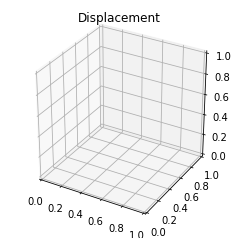

In [11]:
# Plot solution
plot(u, title='Displacement', mode='displacement')

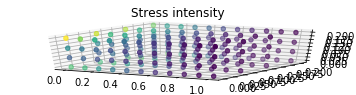

In [12]:
# Plot stress
s = sigma(u) - (1./3)*tr(sigma(u))*Identity(d)  # deviatoric stress
von_Mises = sqrt(3./2*inner(s, s))
V = FunctionSpace(mesh, 'P', 1)
von_Mises = project(von_Mises, V)
plot(von_Mises, title='Stress intensity')

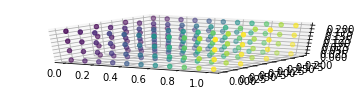

In [13]:
# Compute magnitude of displacement
u_magnitude = sqrt(dot(u, u))
u_magnitude = project(u_magnitude, V)
plot(u_magnitude, 'Displacement magnitude')

# fenics -> yt

The results are stored in `u` where I have not been able to tell if `u` has the mesh coordinates stored within it. putting that aside for a moment lets examine the `mesh` generated by 
```
mesh = BoxMesh(Point(0, 0, 0), Point(L, W, W), 10, 3, 3)
```
where the documents for `BoxMesh` are (https://fenicsproject.org/olddocs/dolfin/1.3.0/python/programmers-reference/cpp/mesh/BoxMesh.html) where it states the resulting mesh is a Tetrahedral mesh. The coordinates of the mech vertices should then be callable and stored in `Mcoords` via:

In [14]:
Mcoords=mesh.coordinates()
print(Mcoords.shape)
Mcoords

(176, 3)


array([[0.        , 0.        , 0.        ],
       [0.1       , 0.        , 0.        ],
       [0.2       , 0.        , 0.        ],
       [0.3       , 0.        , 0.        ],
       [0.4       , 0.        , 0.        ],
       [0.5       , 0.        , 0.        ],
       [0.6       , 0.        , 0.        ],
       [0.7       , 0.        , 0.        ],
       [0.8       , 0.        , 0.        ],
       [0.9       , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 0.06666667, 0.        ],
       [0.1       , 0.06666667, 0.        ],
       [0.2       , 0.06666667, 0.        ],
       [0.3       , 0.06666667, 0.        ],
       [0.4       , 0.06666667, 0.        ],
       [0.5       , 0.06666667, 0.        ],
       [0.6       , 0.06666667, 0.        ],
       [0.7       , 0.06666667, 0.        ],
       [0.8       , 0.06666667, 0.        ],
       [0.9       , 0.06666667, 0.        ],
       [1.        , 0.06666667, 0.        ],
       [0.

The data we wish to see is stored in `u` which will be extracted to `U` thusly

In [15]:
U=u.vector().get_local()
print(U.shape)
U

(528,)


array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  5.08008829e-03,  2.91100131e-04,
       -4.53526583e-03,  5.79034485e-03,  1.05831925e-03, -4.40190290e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.74298392e-03,  2.81428971e-04,
       -3.95206961e-03,  2.10122330e-03,  5.91689712e-04, -3.83491393e-03,
        9.55946557e-03,  8.01949147e-04, -1.30091504e-02,  1.03267096e-02,
        1.38395092e-03, -1.29236194e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  4.69275096e-03, -2.46781203e-04, -4.35755105e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  8.88828238e-03,
        2.72478960e-04, -1.27282845e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -1.34213137e-03,  2.17430325e-04, -3.96323060e-03,
       -1.16993421e-03, -1.92394843e-06, -3.87141136e-03,  3.24597852e-03,
        8.63286339e-04, -

According to http://yt-project.org/doc/examining/loading_data.html in the *Unstructured Grid Data* section and from standard convection of volumetric meshes in OpenGL extra there should be a connectivity (vertex) array which seems to be given by

In [16]:
Mconn=mesh.cells()
print(Mconn.shape)
#recast from unit32 to int64
Mconn=Mconn.astype(np.int64)
Mconn

(540, 4)


array([[  0,   1,  12,  56],
       [  0,   1,  45,  56],
       [  0,  44,  45,  56],
       ...,
       [119, 130, 131, 175],
       [119, 163, 174, 175],
       [119, 130, 174, 175]])

# Viewing the displacement in *yt*

In [17]:
data = dict({('connect1', 'displacment') : U[Mconn]})
ds = yt.load_unstructured_mesh(Mconn, Mcoords, node_data=data)

yt : [INFO     ] 2018-05-17 11:55:13,143 Parameters: current_time              = 0.0
yt : [INFO     ] 2018-05-17 11:55:13,144 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2018-05-17 11:55:13,145 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2018-05-17 11:55:13,146 Parameters: domain_right_edge         = [1.1  0.22 0.22]
yt : [INFO     ] 2018-05-17 11:55:13,148 Parameters: cosmological_simulation   = 0.0


yt : [INFO     ] 2018-05-17 11:55:13,302 xlim = 0.000000 0.220000
yt : [INFO     ] 2018-05-17 11:55:13,303 ylim = 0.000000 0.220000
yt : [INFO     ] 2018-05-17 11:55:13,305 xlim = 0.000000 0.220000
yt : [INFO     ] 2018-05-17 11:55:13,305 ylim = 0.000000 0.220000
yt : [INFO     ] 2018-05-17 11:55:13,307 Making a fixed resolution buffer of (('all', 'displacment')) 800 by 800
yt : [WARNING  ] 2018-05-17 11:55:13,446 Plot image for field ('all', 'displacment') has both positive and negative values. Min = -0.030955, Max = 0.009722.
yt : [WARNING  ] 2018-05-17 11:55:13,446 Switching to symlog colorbar scaling unless linear scaling is specified later



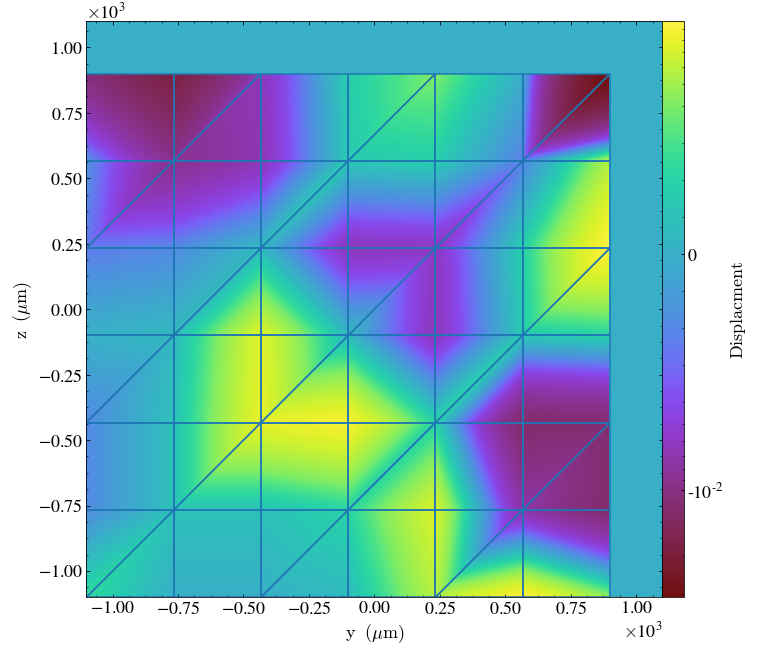

In [18]:
sl = yt.SlicePlot(ds, 'x', 'displacment')
sl.annotate_mesh_lines()

yt : [INFO     ] 2018-05-17 11:55:14,611 xlim = 0.000000 0.220000
yt : [INFO     ] 2018-05-17 11:55:14,613 ylim = 0.000000 1.100000
yt : [INFO     ] 2018-05-17 11:55:14,617 xlim = 0.000000 0.220000
yt : [INFO     ] 2018-05-17 11:55:14,618 ylim = 0.000000 1.100000
yt : [INFO     ] 2018-05-17 11:55:14,623 Making a fixed resolution buffer of (('all', 'displacment')) 800 by 800
yt : [WARNING  ] 2018-05-17 11:55:14,774 Plot image for field ('all', 'displacment') has both positive and negative values. Min = -0.030411, Max = 0.007552.
yt : [WARNING  ] 2018-05-17 11:55:14,775 Switching to symlog colorbar scaling unless linear scaling is specified later



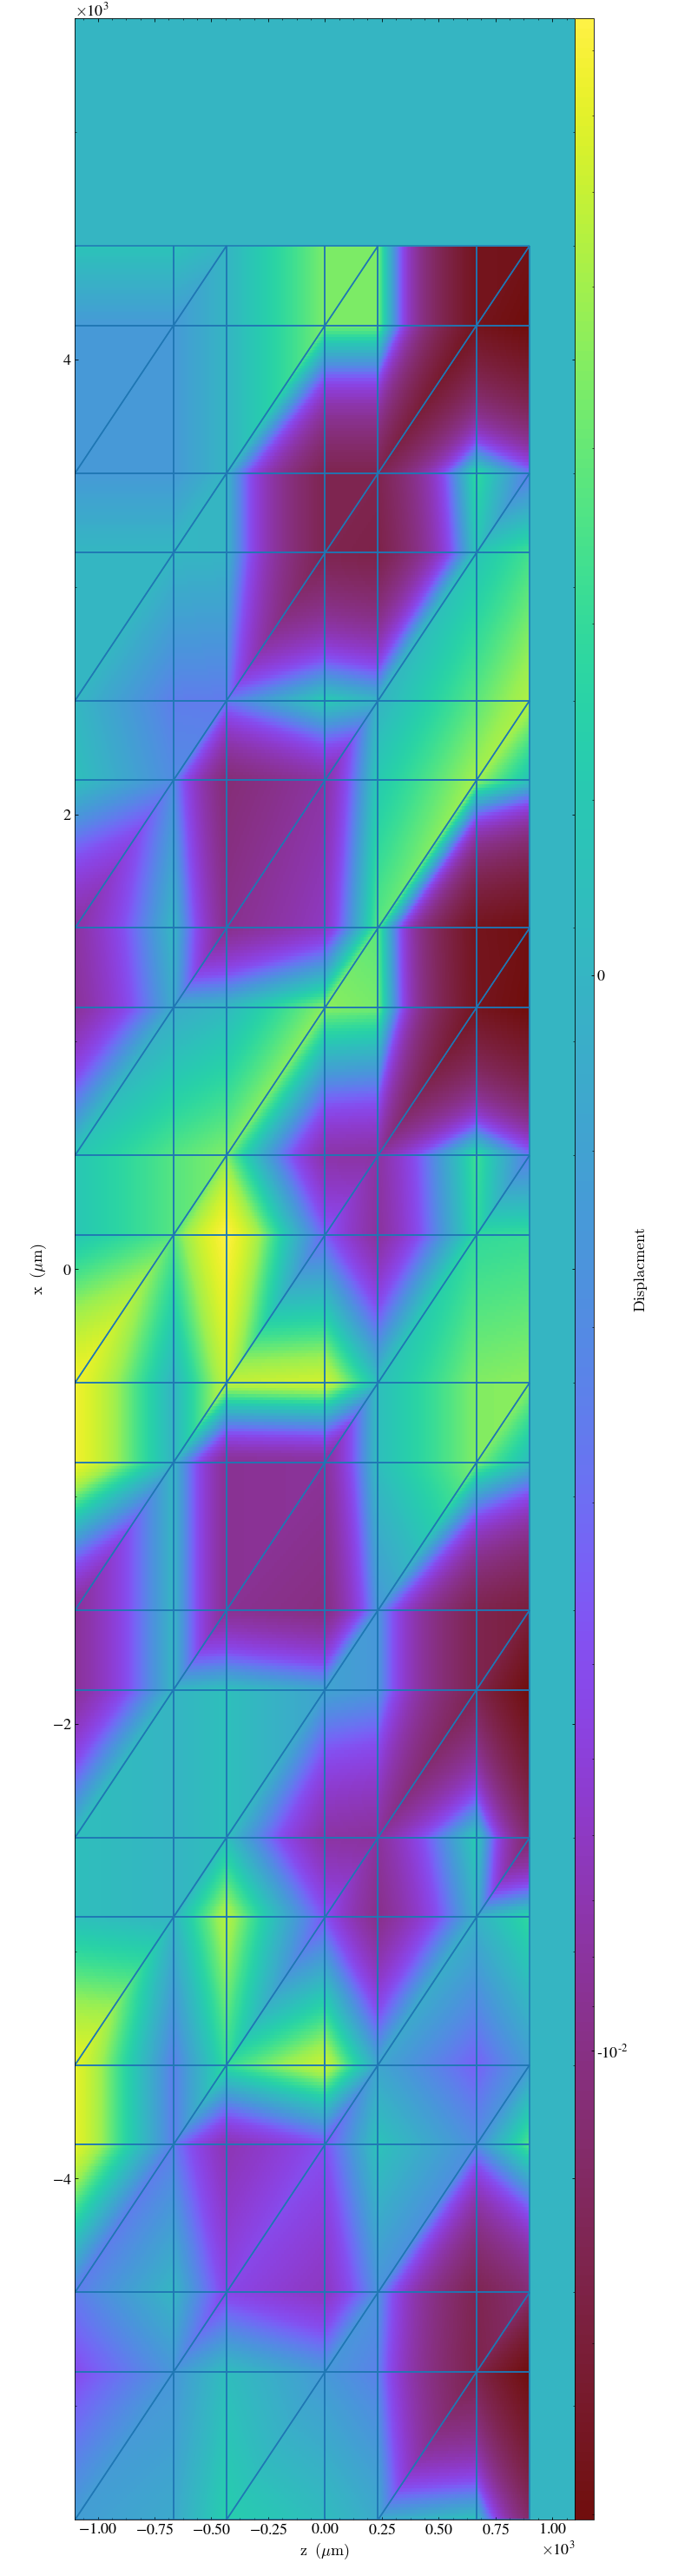

In [19]:
sl = yt.SlicePlot(ds, 'y', 'displacment')
sl.annotate_mesh_lines()

yt : [INFO     ] 2018-05-17 11:55:16,246 xlim = 0.000000 1.100000
yt : [INFO     ] 2018-05-17 11:55:16,247 ylim = 0.000000 0.220000
yt : [INFO     ] 2018-05-17 11:55:16,249 xlim = 0.000000 1.100000
yt : [INFO     ] 2018-05-17 11:55:16,250 ylim = 0.000000 0.220000
yt : [INFO     ] 2018-05-17 11:55:16,255 Making a fixed resolution buffer of (('all', 'displacment')) 800 by 800
yt : [WARNING  ] 2018-05-17 11:55:16,419 Plot image for field ('all', 'displacment') has both positive and negative values. Min = -0.034565, Max = 0.014873.
yt : [WARNING  ] 2018-05-17 11:55:16,420 Switching to symlog colorbar scaling unless linear scaling is specified later



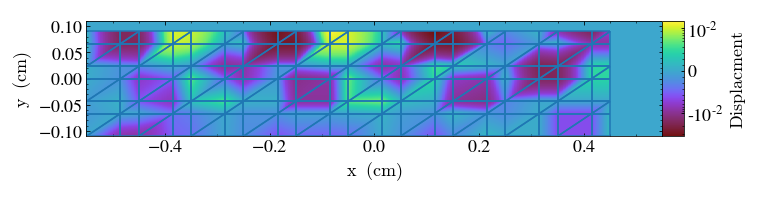

In [20]:
sl = yt.SlicePlot(ds, 'z', 'displacment')
sl.annotate_mesh_lines()

yt : [INFO     ] 2018-05-17 11:55:17,127 Setting default field to ('connect1', 'displacment')
yt : [INFO     ] 2018-05-17 11:55:17,163 Rendering scene (Can take a while).


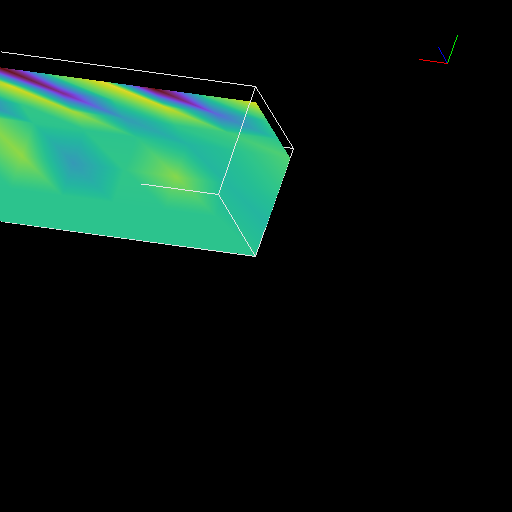

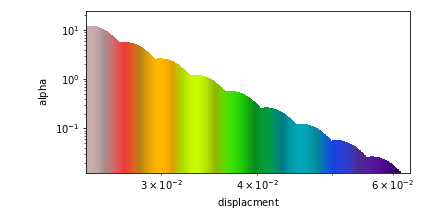

In [21]:
sc = yt.create_scene(ds)
#transfer function
scTF = TransferFunctionHelper(ds)
scTF.set_field('displacment')
scTF.set_bounds((abs(U.mean()-U.std()), U.mean()+U.std()))
scTF.set_log(True)
sc.transfer_function=scTF.tf

#camera controls
cam = sc.add_camera()
cam.position = np.array([0.5, 0.5, -1.0])
cam.north_vector = np.array([0.0, 1.0, 1.0])

sc.annotate_axes()
sc.annotate_domain(ds)
sc.camera.set_width(ds.quan(.009, 'm'))


sc.show(sigma_clip=2)


scTF.plot()

# Loading and viewing the stress

In [22]:
S=von_Mises.vector().get_local(); S.shape

(176,)

In [23]:
data = dict({('connect1', 'stress') : S[Mconn]})
ds = yt.load_unstructured_mesh(Mconn, Mcoords, node_data=data)

yt : [INFO     ] 2018-05-17 11:55:18,814 Parameters: current_time              = 0.0
yt : [INFO     ] 2018-05-17 11:55:18,815 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2018-05-17 11:55:18,816 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2018-05-17 11:55:18,818 Parameters: domain_right_edge         = [1.1  0.22 0.22]
yt : [INFO     ] 2018-05-17 11:55:18,822 Parameters: cosmological_simulation   = 0.0


yt : [INFO     ] 2018-05-17 11:55:18,976 xlim = 0.000000 0.220000
yt : [INFO     ] 2018-05-17 11:55:18,977 ylim = 0.000000 0.220000
yt : [INFO     ] 2018-05-17 11:55:18,978 xlim = 0.000000 0.220000
yt : [INFO     ] 2018-05-17 11:55:18,979 ylim = 0.000000 0.220000
yt : [INFO     ] 2018-05-17 11:55:18,982 Making a fixed resolution buffer of (('all', 'stress')) 800 by 800



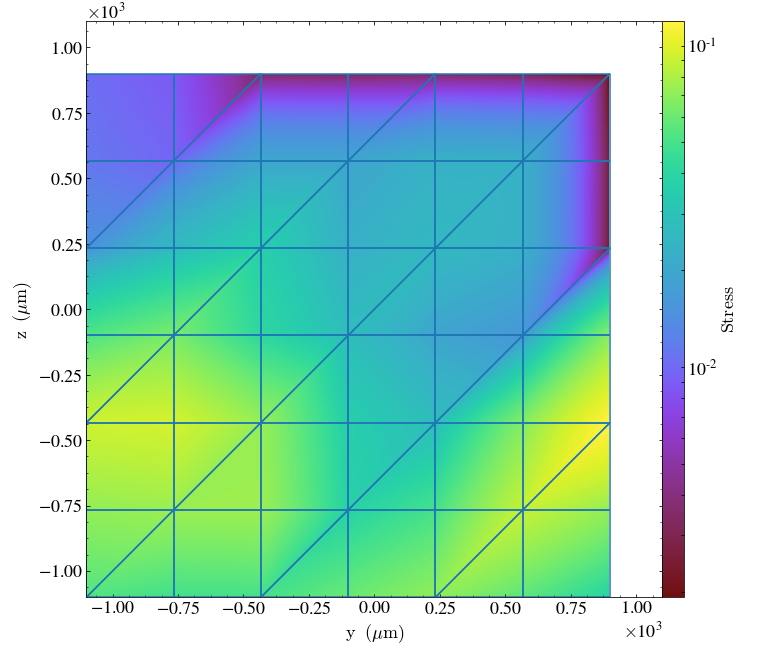

In [24]:
sl = yt.SlicePlot(ds, 'x', 'stress')
sl.annotate_mesh_lines()

yt : [INFO     ] 2018-05-17 11:55:20,141 xlim = 0.000000 0.220000
yt : [INFO     ] 2018-05-17 11:55:20,142 ylim = 0.000000 1.100000
yt : [INFO     ] 2018-05-17 11:55:20,144 xlim = 0.000000 0.220000
yt : [INFO     ] 2018-05-17 11:55:20,148 ylim = 0.000000 1.100000
yt : [INFO     ] 2018-05-17 11:55:20,150 Making a fixed resolution buffer of (('all', 'stress')) 800 by 800



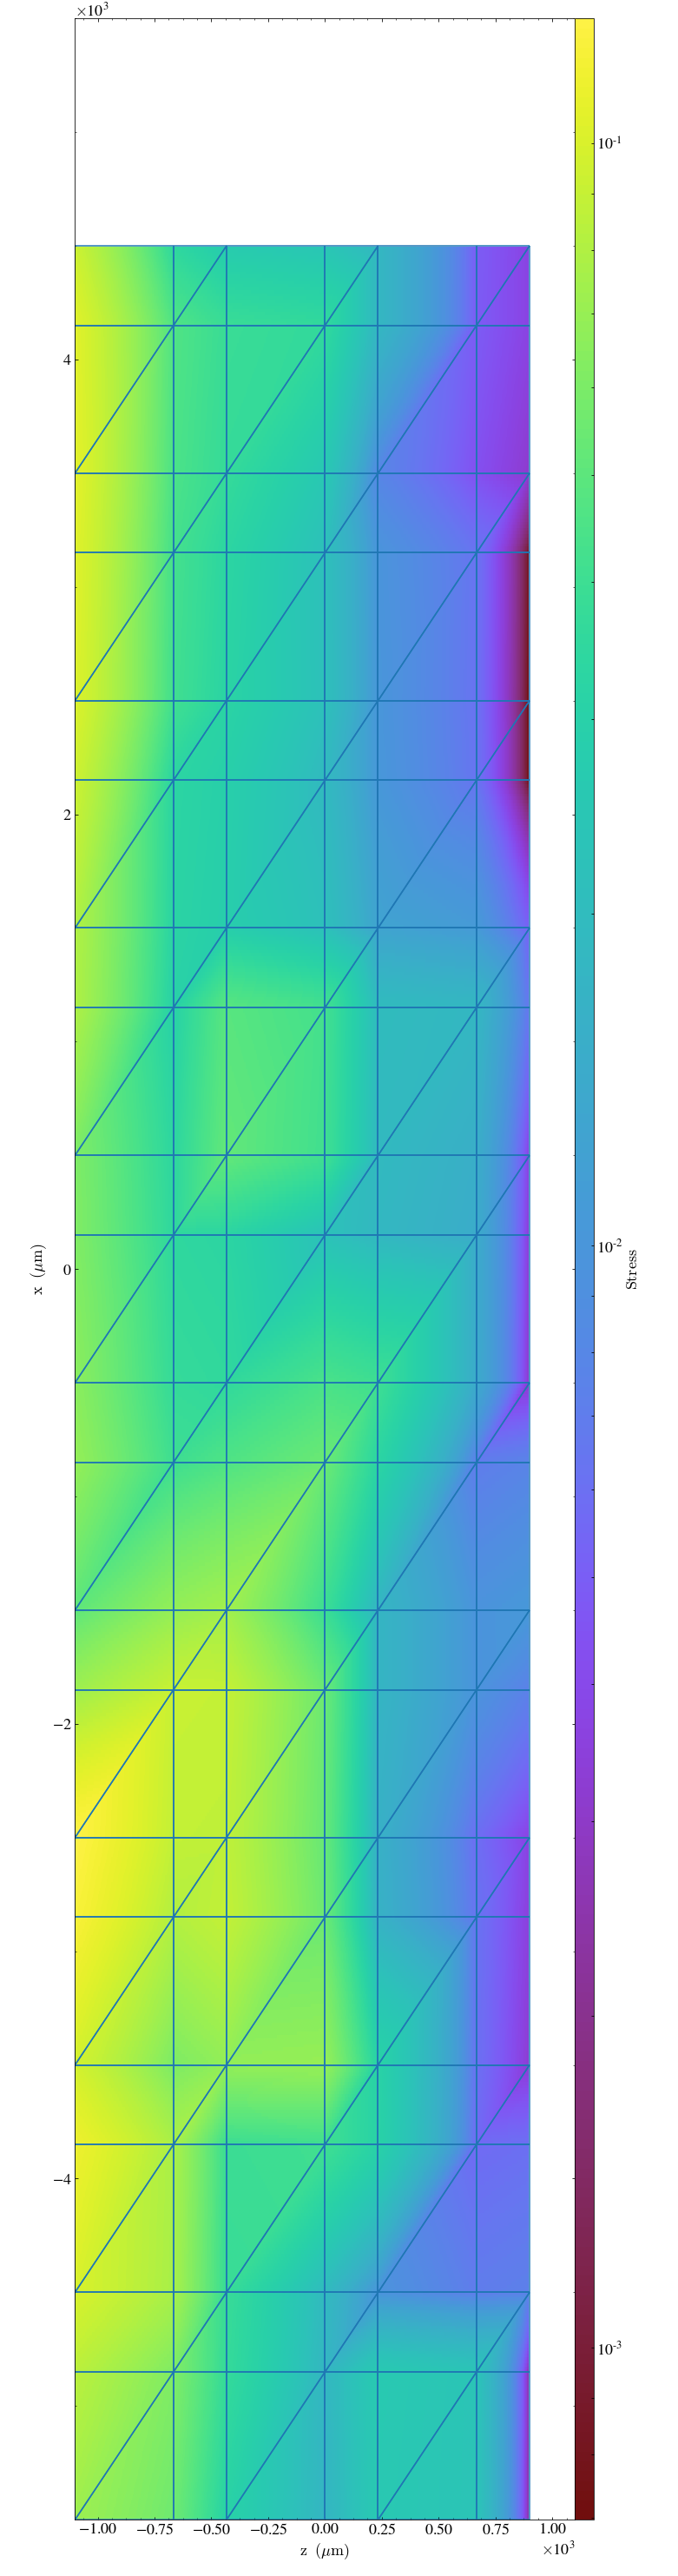

In [25]:
sl = yt.SlicePlot(ds, 'y', 'stress')
sl.annotate_mesh_lines()

yt : [INFO     ] 2018-05-17 11:55:21,786 xlim = 0.000000 1.100000
yt : [INFO     ] 2018-05-17 11:55:21,789 ylim = 0.000000 0.220000
yt : [INFO     ] 2018-05-17 11:55:21,792 xlim = 0.000000 1.100000
yt : [INFO     ] 2018-05-17 11:55:21,794 ylim = 0.000000 0.220000
yt : [INFO     ] 2018-05-17 11:55:21,799 Making a fixed resolution buffer of (('all', 'stress')) 800 by 800



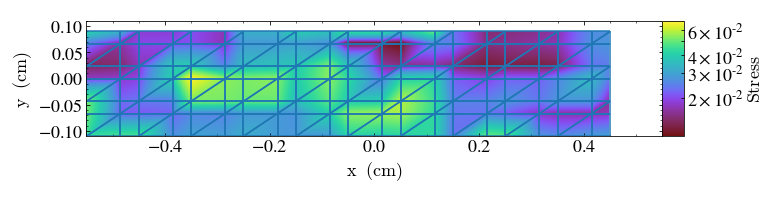

In [26]:
sl = yt.SlicePlot(ds, 'z', 'stress')
sl.annotate_mesh_lines()

yt : [INFO     ] 2018-05-17 11:55:22,733 Setting default field to ('connect1', 'stress')
yt : [INFO     ] 2018-05-17 11:55:22,783 Rendering scene (Can take a while).


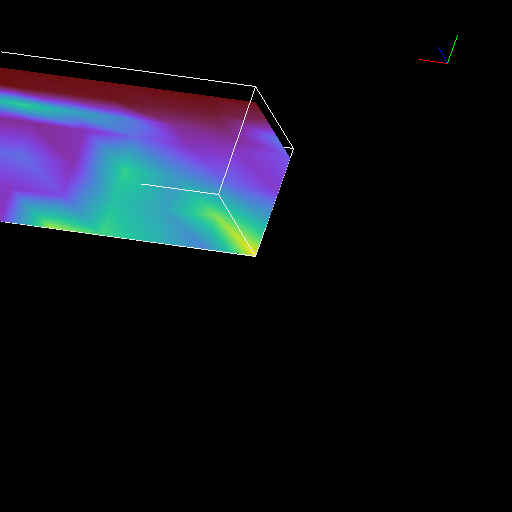

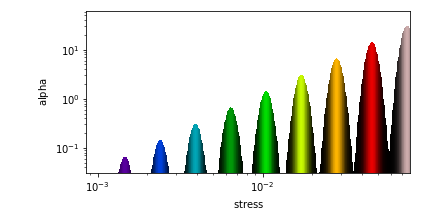

In [27]:
sc = yt.create_scene(ds)
#transfer function
scTF = TransferFunctionHelper(ds)
scTF.set_field('stress')
scTF.set_bounds((abs(S.mean()-S.std()), S.mean()+S.std()))
scTF.set_log(True)
sc.transfer_function=scTF.tf

#camera controls
cam = sc.add_camera()
cam.position = np.array([0.5, 0.5, -1.0])
cam.north_vector = np.array([0.0, 1.0, 1.0])

sc.annotate_axes()
sc.annotate_domain(ds)
sc.camera.set_width(ds.quan(.009, 'm'))


sc.show(sigma_clip=2)


scTF.plot()

# Viewing the displacement magnitude in *yt*

In [28]:
u_magnitude
UM=u_magnitude.vector().get_local(); UM.shape

(176,)

In [29]:
data = dict({('connect1', 'disMag') : UM[Mconn]})
ds = yt.load_unstructured_mesh(Mconn, Mcoords, node_data=data)

yt : [INFO     ] 2018-05-17 11:55:24,653 Parameters: current_time              = 0.0
yt : [INFO     ] 2018-05-17 11:55:24,654 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2018-05-17 11:55:24,658 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2018-05-17 11:55:24,660 Parameters: domain_right_edge         = [1.1  0.22 0.22]
yt : [INFO     ] 2018-05-17 11:55:24,662 Parameters: cosmological_simulation   = 0.0


yt : [INFO     ] 2018-05-17 11:55:25,002 xlim = 0.000000 0.220000
yt : [INFO     ] 2018-05-17 11:55:25,004 ylim = 0.000000 0.220000
yt : [INFO     ] 2018-05-17 11:55:25,008 xlim = 0.000000 0.220000
yt : [INFO     ] 2018-05-17 11:55:25,012 ylim = 0.000000 0.220000
yt : [INFO     ] 2018-05-17 11:55:25,017 Making a fixed resolution buffer of (('all', 'disMag')) 800 by 800



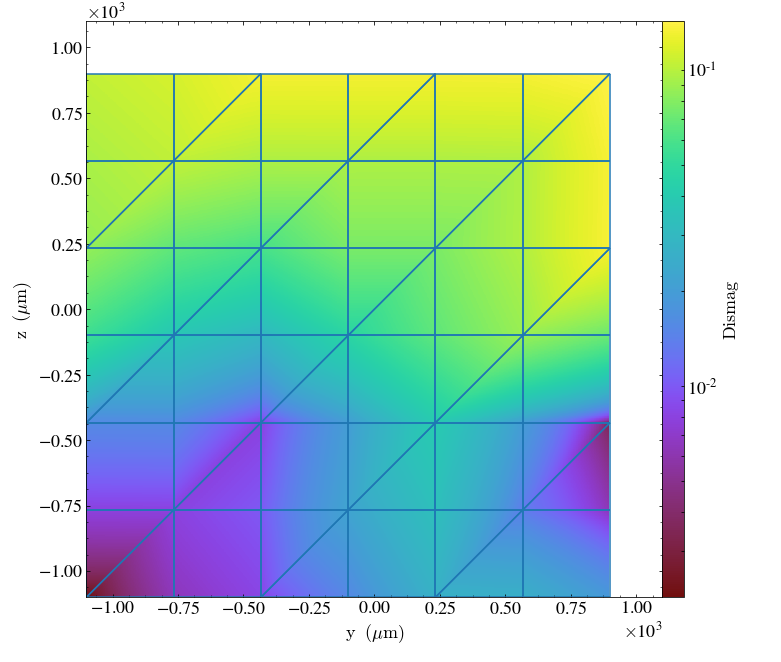

In [30]:
sl = yt.SlicePlot(ds, 'x', 'disMag')
sl.annotate_mesh_lines()

yt : [INFO     ] 2018-05-17 11:55:26,041 xlim = 0.000000 0.220000
yt : [INFO     ] 2018-05-17 11:55:26,043 ylim = 0.000000 1.100000
yt : [INFO     ] 2018-05-17 11:55:26,045 xlim = 0.000000 0.220000
yt : [INFO     ] 2018-05-17 11:55:26,047 ylim = 0.000000 1.100000
yt : [INFO     ] 2018-05-17 11:55:26,056 Making a fixed resolution buffer of (('all', 'disMag')) 800 by 800



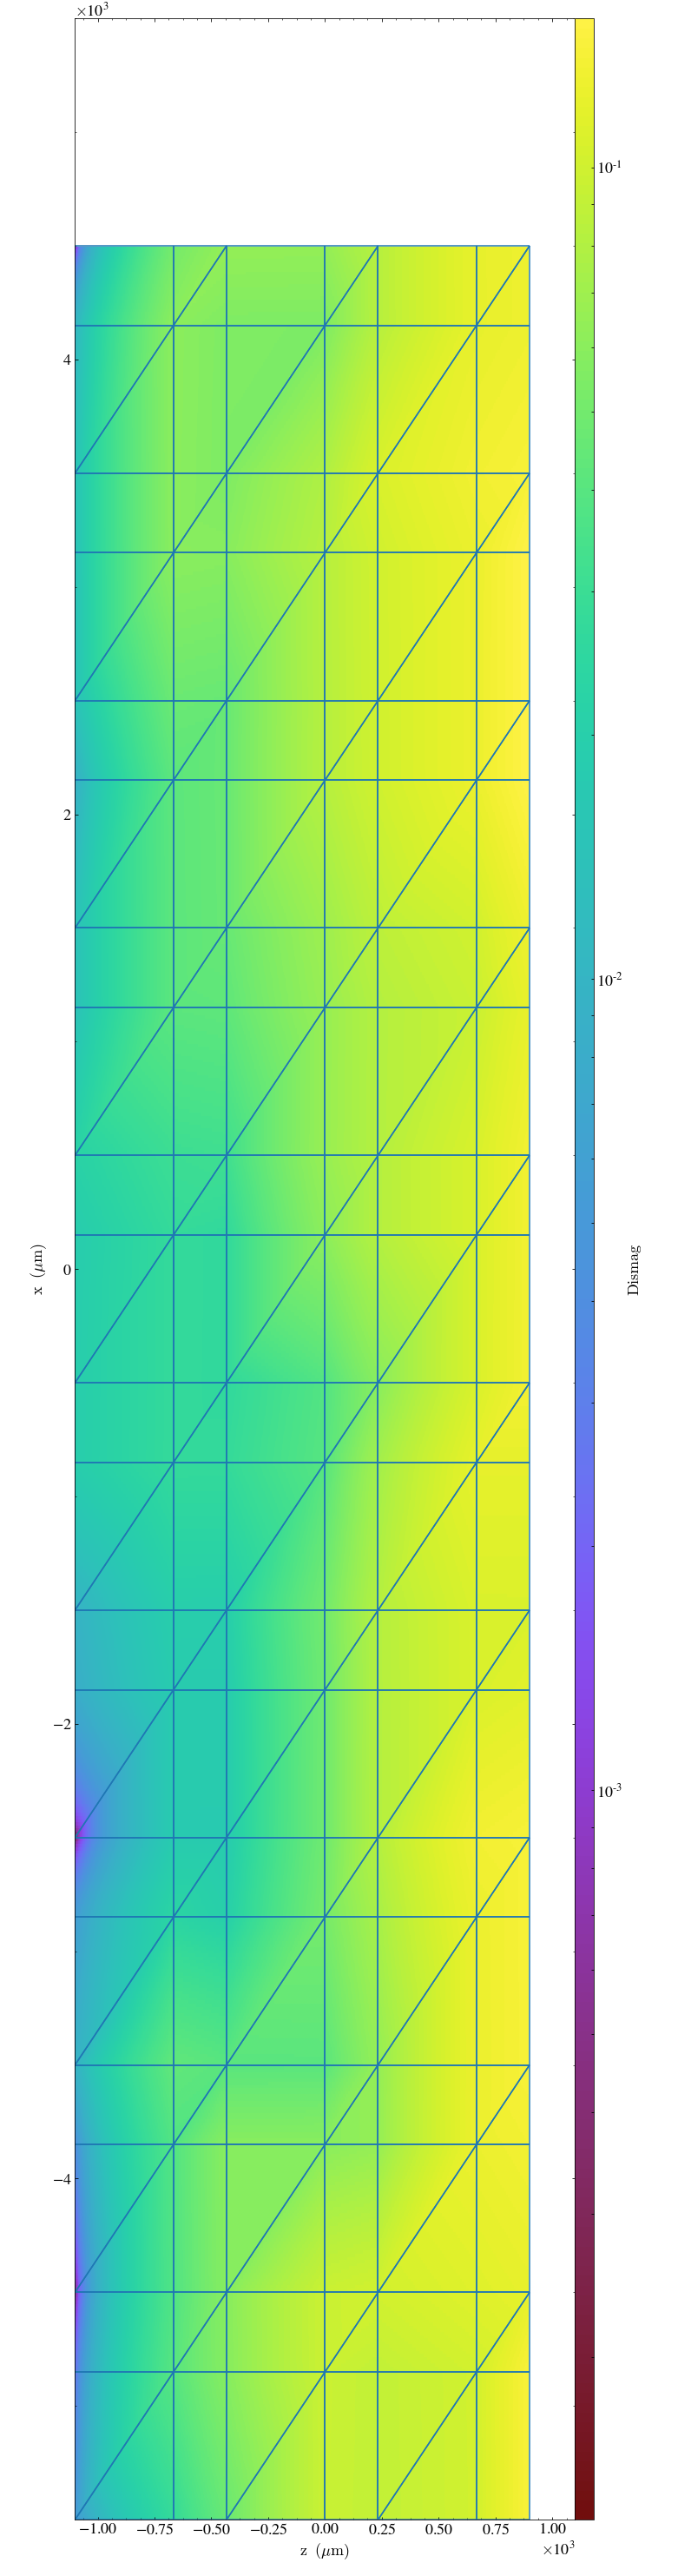

In [31]:
sl = yt.SlicePlot(ds, 'y', 'disMag')
sl.annotate_mesh_lines()

yt : [INFO     ] 2018-05-17 11:55:27,708 xlim = 0.000000 1.100000
yt : [INFO     ] 2018-05-17 11:55:27,709 ylim = 0.000000 0.220000
yt : [INFO     ] 2018-05-17 11:55:27,711 xlim = 0.000000 1.100000
yt : [INFO     ] 2018-05-17 11:55:27,713 ylim = 0.000000 0.220000
yt : [INFO     ] 2018-05-17 11:55:27,715 Making a fixed resolution buffer of (('all', 'disMag')) 800 by 800



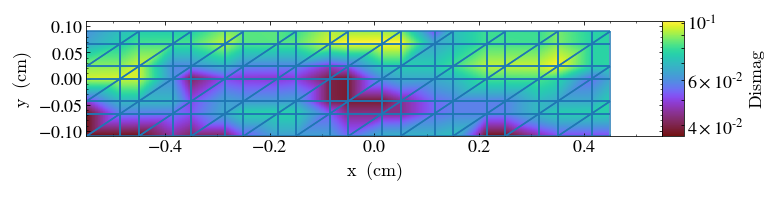

In [32]:
sl = yt.SlicePlot(ds, 'z', 'disMag')
sl.annotate_mesh_lines()

yt : [INFO     ] 2018-05-17 11:55:28,513 Setting default field to ('connect1', 'disMag')
yt : [INFO     ] 2018-05-17 11:55:28,538 Rendering scene (Can take a while).


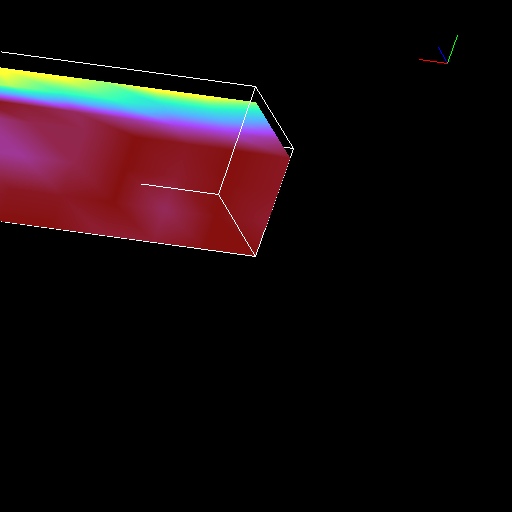

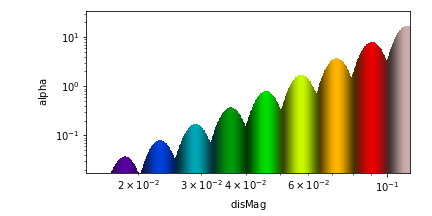

In [33]:
sc = yt.create_scene(ds)
#transfer function
scTF = TransferFunctionHelper(ds)
scTF.set_field('disMag')
scTF.set_bounds((abs(UM.mean()-UM.std()), UM.mean()+UM.std()))
scTF.set_log(True)
sc.transfer_function=scTF.tf

#camera controls
cam = sc.add_camera()
cam.position = np.array([0.5, 0.5, -1.0])
cam.north_vector = np.array([0.0, 1.0, 1.0])

sc.annotate_axes()
sc.annotate_domain(ds)
sc.camera.set_width(ds.quan(.009, 'm'))


sc.show(sigma_clip=2)


scTF.plot()

# Conclusion
As can be seen above *yt* is now a viable alternative to *VTK* and similar 3d visualization tools to visualize the outputs of *FEniCS*. And while the above leaves much to be desired in terms of normal features that *VTK* especially in terms of the volumetric rendering it is a good start that will hopefully lead to more duel use of *yt* and *FEniCS* and contributions to *yt* to give it all the features it needs to move beyond the narrow use Astro-cosmological visualizations to  becoming python defacto volumetric rendering library.

# To Do
1. get better control of the camera
2. compare against the VTK output
3. work with yt to get VTK annotations, ect in to yt outputs